# Decoding of Next-Token Predictions

This note book is designed to reimplement Pathscope **section 1:Next-Token Prediction**

In [1]:
import torch
from collections import defaultdict
from tqdm import tqdm
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

In [160]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of available GPUs
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
1
Tesla P100-PCIE-16GB


In [3]:
! pip install zstandard

In [4]:
# ! pip install datasets

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM,DataCollatorWithPadding
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.amp import autocast
import os
import math
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# import dataloader


In [6]:
model_dict = ["Qwen/Qwen2-0.5B","Qwen/Qwen2.5-0.5B-Instruct","Qwen/Qwen2-1.5B"]

In [7]:
model_num = 0

tokenizer = AutoTokenizer.from_pretrained(model_dict[model_num])
model = AutoModelForCausalLM.from_pretrained(model_dict[model_num]).to(device)
model.eval()

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [8]:
# model(tokenizer('how are you doing today?'))

In [9]:
print(model.__class__.__module__)
print(model.config.model_type)

transformers.models.qwen2.modeling_qwen2
qwen2


In [10]:
type(model)

transformers.models.qwen2.modeling_qwen2.Qwen2ForCausalLM

In [11]:
type(tokenizer)

transformers.models.qwen2.tokenization_qwen2_fast.Qwen2TokenizerFast

In [12]:
# from transformers import Qwen2ForCausalLM
# model2 = Qwen2ForCausalLM.from_pretrained('Qwen/Qwen2-0.5B')

In [13]:
# print(model2)

In [14]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [15]:
# define a function to get hidden states of each layer of the model

def get_hidden_state(model, input_ids):
    with torch.no_grad():
        outputs = model(input_ids.to(device), output_hidden_states=True)
    return outputs.hidden_states[1:]  #Size([batch_size, num_layers, sequence_length, hidden_size])




In [16]:
# load the Pile data "https://huggingface.co/datasets/EleutherAI/pile" from hugging face, unfortunately it is not available
# use the following uncoprighted pile dataset instead
# https://huggingface.co/datasets/monology/pile-uncopyrighted

dataPile= load_dataset("monology/pile-uncopyrighted",split='train',streaming=True)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [17]:
dataPile

IterableDataset({
    features: Unknown,
    num_shards: 30
})

In [18]:
# shuffle the dataset before spliting them
# reference resource "https://huggingface.co/docs/datasets/v3.3.2/stream"

dataPile = dataPile.shuffle(seed=50)
training_data = dataPile.take(10000)
# train : val = 5 : 1
validation_data = dataPile.skip(10000).take(2000)

In [161]:
list(validation_data)[:4]

In [20]:
text = "1. Field of the Invention\nThe present invention relates to toothbrushes and, in particular, to a toothbrush having a hollow handle defining a paste-holding cavity wherein toothpaste is forcibly dispensed therefrom"

In [163]:
tokenizer([text,'hee asdf po afsdf '], return_tensors="pt",max_length=21, truncation=True, padding="max_length")

{'input_ids': tensor([[    16,     13,   8601,    315,    279,    758,   7459,    198,    785,
           3042,  27130,  35616,    311,  25507,  36061,    288,    323,     11,
            304,   3953,     11],
        [ 49053,    438,   2940,   3193,  66713,   2940,    220, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [22]:

import random

def preprocess(example):

    text = example['text']
    inputs = tokenizer(text, return_tensors='pt', max_length=50, truncation=True) # dict_keys(['input_ids', 'attention_mask'])
    inputs_ids = inputs['input_ids'][0] # becasue the batch size is 1

    if len(inputs_ids) > 5:
        trim_len = random.randint(5,  len(inputs_ids) -1)   # to introduce randomness in the training data
        inputs_ids = inputs_ids[:trim_len]

    return {'input_ids': inputs_ids, 'attention_mask': inputs['attention_mask'][0][:len(inputs_ids)]}

In [23]:
training_data = training_data.map(preprocess,remove_columns=['text','meta'])
validation_data = validation_data.map(preprocess,remove_columns=['text','meta'])

In [24]:
next(iter(training_data))

{'input_ids': tensor([   35,   321,  1345,   496,   220,    16,    24,    24,    23,   271,
         38704, 10099,   279,  2480,  5700, 52767,  1345,   496,  2860,  1283,
           279,  4285, 12227,  2219, 17938,  1056,   271,    32,  5612,  8735,
          1728,    11,   264, 16851,   369,  7748,  3669]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [25]:
# we can change the attentino mask to focus on the token of interest

In [26]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
# PyTorch
torch.cuda.memory_summary()

# Or more detailed
torch.cuda.memory_allocated()
torch.cuda.memory_reserved()


2097152000

## 1. Logit lens

In [28]:
# each_layer_logit_lens = {l : [] for l in range(len(24))}



each_layer_logit_lens_Precision = defaultdict(list) # key = int:layer , value = list[]
each_layer_logit_lens_Surprisal = defaultdict(list)

def logit_len_for_test(hidden_states,refernce_logits):
    pass



def logit_len(hidden_states,mask,refernce_logits):
    """

    hidden_states: Tuple[Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model

    mask: Size([batch_size, sequence_length])

    refernce_logits: Size([batch_size, sequence_length, vocab_size]): this will be converted to Size([batch_size, vocab_size])

    """
    W_U = model.lm_head.weight

    # using attention mask to get the last token of the sequence

    num_layer  = len(hidden_states)
    batch_size, sequence_length, hidden_size = hidden_states[0].shape

    last_token_pos = torch.sum(mask,dim=1) # Size([batch_size])

    reference_logits = refernce_logits[torch.arange(len(mask)),last_token_pos -1 ,:] # Size([batch_size, vocab_size])
    reference_logits_max_token = torch.argmax(reference_logits,dim = -1)

    def suprisla(reference_logist, logist):
        predicted_tokens = torch.argmax(logits, dim=-1)  # Shape: (batch_size,)
        reference_probs = torch.nn.functional.softmax(reference_logits, dim=-1)
        predicted_token_probs = reference_probs[torch.arange(batch_size), predicted_tokens]
        surprisal = -torch.log(predicted_token_probs + 1e-9)

        return torch.sum(surprisal)



    for idx, each_layer in enumerate(hidden_states):
        layer_hidden = each_layer[torch.arange(batch_size),last_token_pos-1] # Size([batch_size, hidden_size])
        # layer_hidden = layer_hidden[torch.arange(batch_size),:] # Size([batch_size, hidden_size])
        logits = torch.einsum('bd,vd->bv', layer_hidden, W_U)  # Size([batch_size, vocab_size])
        logits_max_token = torch.argmax(logits,dim = -1)

        identical_samples = torch.sum(logits_max_token == reference_logits_max_token)
        each_layer_logit_lens_Precision[idx].append(identical_samples)
        each_layer_logit_lens_Surprisal[idx].append(suprisla(reference_logits,logits))
        # print(identical_samples)


    return

batch_size = 32

i = 0
for batch in tqdm(DataLoader(validation_data, batch_size=batch_size, collate_fn=data_collator),total = math.ceil(2000/batch_size),desc = f"logit_lens_exp"):
    # print(batch)k
    batch.to(device)
    with torch.no_grad():
        model_outputs = model(**batch,output_hidden_states=True)
        hidden_states = model_outputs.hidden_states[1:]  # exclude the embedding layer
        reference_logits = model_outputs.logits
        mask = batch['attention_mask']

    # reference_logits = reference_logits[torch.arange(len(mask)),torch.sum(mask,dim=1)] # Size([batch_size, vocab_size])
    Compare_logit = logit_len(hidden_states,mask,reference_logits)
    # i += 1
    # print('one batch done')

    # if i >= 2:
    #     break

logit_lens_exp: 100%|██████████| 63/63 [00:28<00:00,  2.17it/s]


In [29]:
# Clear GPU cache
# torch.cuda.empty_cache()

In [30]:
# print(# PyTorch
# torch.cuda.memory_summary())

# # Or more detailed
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_reserved())

#### Metric
1. Precision@1
2. Suprisal

In [112]:
def precision(a):
    """
    a : dict[layer] =  list[]
    """
    for k, v in a.items():
        a[k] = torch.stack(v,dim = 0).sum() / 2000

    return a


def surprisal(a):

    for k,v in a.items():
        a[k] = torch.stack(v,dim = 0).sum()/2000

    return a



In [ ]:
logit_len_p = precision(each_layer_logit_lens_Precision)
logit_len_s = surprisal(each_layer_logit_lens_Surprisal)

In [164]:
# torch.save(logit_len_p,f"/content/drive/MyDrive/Patchscope-Reimplementation-main/Decoding_of_next_token_Prediction/logit_len_P_{model_dict[model_num].split('/')[-1]}.pt")
# torch.save(logit_len_s,f"/content/drive/MyDrive/Patchscope-Reimplementation-main/Decoding_of_next_token_Prediction/logit_len_S_{model_dict[model_num].split('/')[-1]}.pt")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [167]:
# logit_len_p[:5]

In [168]:
print(model_outputs['logits'].shape)
print(model_outputs['hidden_states'][4].shape)

torch.Size([16, 49, 151936])
torch.Size([16, 49, 896])


In [35]:
len(model_outputs['hidden_states'])

25

## 2. Tuned Lens

In [36]:
from sklearn.linear_model import LinearRegression

import numpy as np


config = model.config
num_layers = config.num_hidden_layers

X_train = {l : [] for l in range(num_layers)}
Y_train = []  # finaly layer logits



batch_size = 32

def get_last_token_hidden_states(hidden_states,mask) -> None:
    """
    hiddenstates: Tuple[Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model
    """

    last_token_pos = torch.sum(mask,dim=1) # Size([batch_size])

    for i, layer in enumerate(hidden_states):
        X_train[i].append(layer[torch.arange(len(mask)),last_token_pos -1 ,:].cpu().numpy())   # Size([batch_size, hidden_size])

    Y_train.append(hidden_states[-1][torch.arange(len(mask)),last_token_pos -1 ,:].cpu().numpy())   # Size([batch_size, hidden_size]))

# to get the hidden states of each sequence
for batch in tqdm(DataLoader(training_data, batch_size=batch_size, collate_fn=data_collator),total = math.ceil(10000 / batch_size) ,desc = "affine map training data"):
    batch.to(device)
    with torch.no_grad():
        model_outputs = model(**batch,output_hidden_states=True)
    # batch.to('cpu')
    hidden_states = model_outputs.hidden_states[1:] # exclude the embedding layer
    mask = batch['attention_mask'].cpu()
    reference_logits = model_outputs.logits

    get_last_token_hidden_states(hidden_states,mask)

#     del batch, model_outputs
#     torch.cuda.empty_cache()  # Clear GPU cache



affine map training data: 100%|██████████| 313/313 [02:09<00:00,  2.41it/s]


In [37]:
X_train[0][-1].shape

(16, 896)

In [38]:
len(Y_train)

313

In [39]:
# for each layer,train a affing transformation to predict the final layer logits

Y_train = np.concatenate(Y_train,axis=0) # Size([num_samples, hidden_size])

affine_map_house = []

for i in range(num_layers):
    affine_map = LinearRegression(fit_intercept=True)
    X_train[i] = np.concatenate(X_train[i],axis=0) # Size([num_samples, hidden_size])
    affine_map.fit(X_train[i],Y_train)
    affine_map_house.append(affine_map)
    # break


In [120]:

# do the same thing as logit_len but with the affine transformation bewteen the hidden states of each layer and the final layer logits
each_layer_tuned_lens_Precision = defaultdict(list)
each_layer_tuned_lens_Surprisal = defaultdict(list)

def tuned_len(hidden_states,mask,refernce_logits,model = model):
    """

    hidden_states: Tuple[Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model

    mask: Size([batch_size, sequence_length])

    refernce_logits: Size([batch_size, sequence_length, vocab_size]): this will be converted to Size([batch_size, vocab_size])

    """
    W_U = model.lm_head.weight

    # using attention mask to get the last token of the sequence

    num_layer  = len(hidden_states)
    batch_size, sequence_length, hidden_size = hidden_states[0].shape

    last_token_pos = torch.sum(mask,dim=1) # Size([batch_size])

    reference_logits = refernce_logits[torch.arange(len(mask)),last_token_pos -1 ,:] # Size([batch_size, vocab_size])
    reference_logits_max_token = torch.argmax(reference_logits,dim = -1)

    def suprisla(reference_logist, logist):
        predicted_tokens = torch.argmax(logits, dim=-1)  # Shape: (batch_size,)
        reference_probs = torch.nn.functional.softmax(reference_logits, dim=-1)
        predicted_token_probs = reference_probs[torch.arange(batch_size), predicted_tokens]
        surprisal = -torch.log(predicted_token_probs + 1e-9)

        return torch.sum(surprisal)


    for i , each_layer in enumerate(hidden_states):
        layer_hidden = each_layer[torch.arange(batch_size),last_token_pos-1] # Size([batch_size, hidden_size]

        #***************************************************************
        # the only changes compared to logit_len
        affine_map = affine_map_house[i]   #这里竟然没有报错，当我只有第一个layer的affine map的时候
        layer_hidden_mapped = affine_map.predict(layer_hidden.cpu().numpy())
        layer_hidden_mapped = torch.tensor(layer_hidden_mapped).to(device)



        #***************************************************************
        logits = torch.einsum('bd,vd->bv', layer_hidden_mapped, W_U)  # Size([batch_size, vocab_size])
        logits_max_token = torch.argmax(logits,dim = -1)

        identical_samples = torch.sum(logits_max_token == reference_logits_max_token)
        each_layer_tuned_lens_Precision[i].append(identical_samples)
        each_layer_tuned_lens_Surprisal[i].append(suprisla(reference_logits,logits))
        # print(identical_samples)
        # print(torch.sum(logits_max_token == reference_logits_max_token))


batch_size = 32

i = 0
for batch in tqdm(DataLoader(validation_data, batch_size=batch_size, collate_fn=data_collator),total = math.ceil(2000/batch_size),desc = "tuned_len_exp"):
    # print(batch)k
    batch.to(device)
    with torch.no_grad():
        model_outputs = model(**batch,output_hidden_states=True)
        hidden_states = model_outputs.hidden_states[1:]  # exclude the embedding layer
        reference_logits = model_outputs.logits
        mask = batch['attention_mask']

    # reference_logits = reference_logits[torch.arange(len(mask)),torch.sum(mask,dim=1)] # Size([batch_size, vocab_size])
    Compare_logit = tuned_len(hidden_states,mask,reference_logits)
    i += 1
    # print('one batch done')

    # if i >= 5:
    #     break

tuned_len_exp: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]


In [121]:
tuned_len_p = precision(dict(each_layer_tuned_lens_Precision))
tuned_len_s = surprisal(dict(each_layer_tuned_lens_Surprisal))

In [42]:
# torch.save(tuned_len_p,f"/content/drive/MyDrive/Patchscope-Reimplementation-main/Decoding_of_next_token_Prediction/tuned_len_P_{model_dict[model_num].split('/')[-1]}.pt")
# torch.save(tuned_len_p,f"/content/drive/MyDrive/Patchscope-Reimplementation-main/Decoding_of_next_token_Prediction/tuned_len_S_{model_dict[model_num].split('/')[-1]}.pt")

In [123]:
tuned_len_s

{0: tensor(5.4009, device='cuda:0'),
 1: tensor(5.3014, device='cuda:0'),
 2: tensor(5.0947, device='cuda:0'),
 3: tensor(4.8471, device='cuda:0'),
 4: tensor(4.7935, device='cuda:0'),
 5: tensor(4.7965, device='cuda:0'),
 6: tensor(4.6784, device='cuda:0'),
 7: tensor(4.5961, device='cuda:0'),
 8: tensor(4.6342, device='cuda:0'),
 9: tensor(4.5494, device='cuda:0'),
 10: tensor(4.5646, device='cuda:0'),
 11: tensor(4.4043, device='cuda:0'),
 12: tensor(4.3386, device='cuda:0'),
 13: tensor(4.1975, device='cuda:0'),
 14: tensor(4.0629, device='cuda:0'),
 15: tensor(3.8661, device='cuda:0'),
 16: tensor(3.3011, device='cuda:0'),
 17: tensor(2.9505, device='cuda:0'),
 18: tensor(2.7528, device='cuda:0'),
 19: tensor(2.4907, device='cuda:0'),
 20: tensor(2.0943, device='cuda:0'),
 21: tensor(1.6561, device='cuda:0'),
 22: tensor(1.3515, device='cuda:0'),
 23: tensor(1.0747, device='cuda:0')}

In [43]:
X_train[0].shape

(10000, 896)

In [44]:
Y_train.shape

(10000, 896)

we can conclude that tuned lens really outputperform vallina logit lean

## 3.Token Identitiy Patchscope

set the hidden state at the specic layer and position to the last

### A. Construct **Few-Shot Token Identity Prompts**

In [45]:
# sample a random set of k tokens for all the models, where k was also randomly sampled from the interval [1, . . . , 10].

# to construct 5 realization of token iDs series of variable length

def craft_realization() -> torch.Tensor:
    """
    return: Size([num_realization, num_tokens])
    """

    identity_prompts = []

    num_realization = 5

    for j in range(num_realization):
        num_tokens = random.sample(range(tokenizer.vocab_size),random.randint(1,10))
        prompt = ';'.join([ f"{tokenizer.decode([i])} -> {tokenizer.decode([i])}"  for i in num_tokens]) + '; ?'
        identity_prompts.append(prompt)


    return identity_prompts

identity_token_prompts = craft_realization()




In [46]:
print(identity_token_prompts)

['🗳 -> 🗳; ?', '身體 -> 身體; dental ->  dental;$id -> $id;steel -> steel; receipts ->  receipts;CHILD -> CHILD; badass ->  badass;trägt -> trägt;煌 -> 煌; ?', ' אתר ->  אתר; Indicator ->  Indicator; kvinder ->  kvinder;.idx -> .idx;erno -> erno; contextual ->  contextual; ?', ' Emil ->  Emil;.cluster -> .cluster; appreciation ->  appreciation;<T -> <T;大腿 -> 大腿;aries -> aries;盛 -> 盛; useState ->  useState;_CYCLE -> _CYCLE;בקש -> בקש; ?', ' Harley ->  Harley; ?']


In [47]:
identity_token_prompts[0] 

'🗳 -> 🗳; ?'

In [48]:
# tokenizer.tokenize(identity_token_prompts[0])

In [49]:
debug_idx = 23
debug = False


def patch_hidden_state(source_hidden_states : tuple,batch_length:torch.Tensor, model=model,target_prompt = None) -> None:
    """
    source_hidden_states: Tuple[Tensor:Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model
    batch_length: Size([batch_size])

    target_prompt: str: the prompt the patched hidden states should be conditioned on

    """
    patched_results = {l : [] for l in range(len(source_hidden_states))}


    for layer_index, layer in enumerate(source_hidden_states):

        layer = layer[torch.arange(len(batch_length)),batch_length -1 ,:] # Size([batch_size, hidden_size])


        for i in range(layer.shape[0]):

            hs_to_be_patched = layer[i]

            # set a farward hook function
            def patch_hidden_hook(module, input, output):
                """
                input: Tuple[Tensor:Size([batch_size, sequence_length, hidden_size])]
                output: Tuple[Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model

                """
                if debug:
                    if layer_index == debug_idx:
                        print(f"Before modification: {output[0][0, -1][:6]}")
                    
                output[0][0,-1] = hs_to_be_patched

                if debug :

                    if layer_index == debug_idx:  # for debugging reason
    
                        print(f"After modification: {output[0][0, -1][:6]}")
                        # print(output[0][0,-1][:6])
                        # return output
                        # print(len(output))
                        # print(len(input))


            # set a hook to the target layer
            hook_handle = model.model.layers[layer_index].register_forward_hook(patch_hidden_hook)

            with torch.no_grad():
                output_Target = model(**tokenizer(target_prompt,return_tensors='pt').to(device),output_hidden_states=True)
                target_logits = output_Target.logits[0][-1]
                patched_results[layer_index].append(target_logits)

            hook_handle.remove()


            if debug:
                if layer_index == debug_idx:  # for debugging reason
                    print(output_Target.hidden_states[debug_idx + 1 ][0][-1][:6])


    for k,v in patched_results.items():
        patched_results[k] = torch.stack(v)

    return patched_results



In [50]:
debug_idx = 23
debug = False
def patch_hidden_state_batch(source_hidden_states : tuple,batch_length:torch.Tensor, model=model,target_prompt = None) -> None:
    """
    source_hidden_states: Tuple[Tensor:Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model
    batch_length: Size([batch_size])

    target_prompt: str: the prompt the patched hidden states should be conditioned on

    """
    patched_results = {l : None for l in range(len(source_hidden_states))}

    target_prompts = [target_prompt for i in range(len(batch_length))]
    for layer_index, layer in enumerate(source_hidden_states):

        hs_to_be_patched = layer[torch.arange(len(batch_length)),batch_length -1 ,:] # Size([batch_size, hidden_size])

        # set a farward hook function
        def patch_hidden_hook(module, input, output):
            """
            input: Tuple[Tensor:Size([batch_size, sequence_length, hidden_size])]
            output: Tuple[Size([batch_size, sequence_length, hidden_size])]: the hidden states of each layer of the model

            """
            if debug:
                if layer_index == debug_idx:
                    print(f"Before modification: {output[0][torch.arange(len(batch_length)), -1][:6]}")
                
            output[0][torch.arange(len(batch_length)),-1] = hs_to_be_patched

            if debug :
                if layer_index == debug_idx:  # for debugging reason

                    print(f"After modification: {output[0][torch.arange(len(batch_length)), -1][:6]}")
                    # print(output[0][0,-1][:6])
                    # return output
                    # print(len(output))
                    # print(len(input))


        # set a hook to the target layer
        hook_handle = model.model.layers[layer_index].register_forward_hook(patch_hidden_hook)

        with torch.no_grad():
            
            output_Target = model(**tokenizer(target_prompts,return_tensors='pt').to(device),output_hidden_states=True)
            target_logits = output_Target.logits[torch.arange(len(batch_length)), -1]  #(batch_size, vocab_size)
            patched_results[layer_index] = (target_logits)

        hook_handle.remove()


        if debug:
            if layer_index == debug_idx:  # for debugging reason
                print(output_Target.hidden_states[debug_idx + 1 ][0][-1][:6])
                
    # for k,v in patched_results.items():
    #     patched_results[k] = torch.stack(v)

    return patched_results



In [51]:
tokenizer(identity_token_prompts[0],return_tensors='pt',padding=True)['input_ids'].shape


torch.Size([1, 7])

In [52]:
identity_token_P = [defaultdict(list) for i in range(5)]
identity_token_S = [defaultdict(list) for i in range(5)]
def cal_precision_1(source, target,sources_length,storage_temp):
    """
    source: Size([batch_size, sequence_len, vocab_size])
    target: Dict(K: num_layer, V: Size([batch_size, vocab_size]))
    storage_temp : defaultdict(list)
    """
    
    source = source[torch.arange(len(sources_length)),sources_length -1 ,:] # Size([batch_size, vocab_size])

    for i in range(len(target)):
        storage_temp[i].append(torch.sum(torch.argmax(source,dim=-1) == torch.argmax(target[i],dim=-1),dim = 0))
        # print(torch.sum(torch.argmax(source,dim=-1) == torch.argmax(target[i],dim=-1),dim = 0) /4)

def cal_surpisal(source, target,sources_length,storage_temp):
    """
    source: Size([batch_size, sequence_len, vocab_size])
    target: Dict(K: num_layer, V: Size([batch_size, vocab_size]))

    """
    source = source[torch.arange(len(sources_length)),sources_length -1,:] # Size([batch_size, vocab_size])
    reference_probs = torch.nn.functional.softmax(source, dim=-1)

    for i in range(len(target)):
            
        predicted_tokens = torch.argmax(target[i], dim=-1)  # Shape: (batch_size,)

        # print(f" the size of reference_probs is {reference_probs.shape}")
        
        predicted_token_probs = reference_probs[torch.arange(len(sources_length)), predicted_tokens]
        surprisal = -torch.log(predicted_token_probs + 1e-9)
        storage_temp[i].append(torch.sum(surprisal))
        # print(torch.sum(surprisal)/4)

In [53]:
for idx, prompt in enumerate(identity_token_prompts):

    # get the hidden satate of the prompt at the last positon


    batch_size = 64
    
    for batch in tqdm(DataLoader(validation_data, batch_size=batch_size ,collate_fn=data_collator),total = math.ceil(2000/ batch_size), desc = f"{idx} round patchscope_exp"):
        batch.to(device)
        # run the first forward pass on the source prompt
        with torch.no_grad():
            # with autocast('cuda'):
            # print("hello 123")
            model_outputs = model(**batch,output_hidden_states=True)
            # print("heelo ")
            hidden_states = model_outputs.hidden_states[1:]
            reference_logits = model_outputs.logits # Size([batch_size, sequence_length, vocab_size])
            batch_length = torch.sum(batch['attention_mask'],dim=1)

        target_logtis = patch_hidden_state_batch(hidden_states,batch_length,target_prompt=prompt)
        
        if debug:
            print(hidden_states[debug_idx][torch.arange(batch_size),batch_length - 1,:][:6])
    
        
        cal_precision_1(reference_logits,target_logtis,batch_length,identity_token_P[idx])
        cal_surpisal(reference_logits,target_logtis,batch_length,identity_token_S[idx])
    #     break
    # break


4 round patchscope_exp: 100%|██████████| 32/32 [01:38<00:00,  3.07s/it]


In [105]:
len(identity_token_P[0])

24

In [114]:

    
def avg_token_identity(a,metric):
    ans = defaultdict(list)
    if metric == "p":
        for i in a:
            temp = precision(i)
            for k,v in temp.items():
                ans[k].append(v)
            
    else:
        for i in a:
            temp = surprisal(i)
            for k,v in temp.items():
                ans[k].append(v)

    for k,v in ans.items():
        ans[k] = torch.stack(v,dim = 0).sum() / 5
    return ans


token_identity_pre = avg_token_identity(copy.deepcopy(identity_token_P),"p")
token_identity_sup = avg_token_identity(copy.deepcopy(identity_token_S),"s")




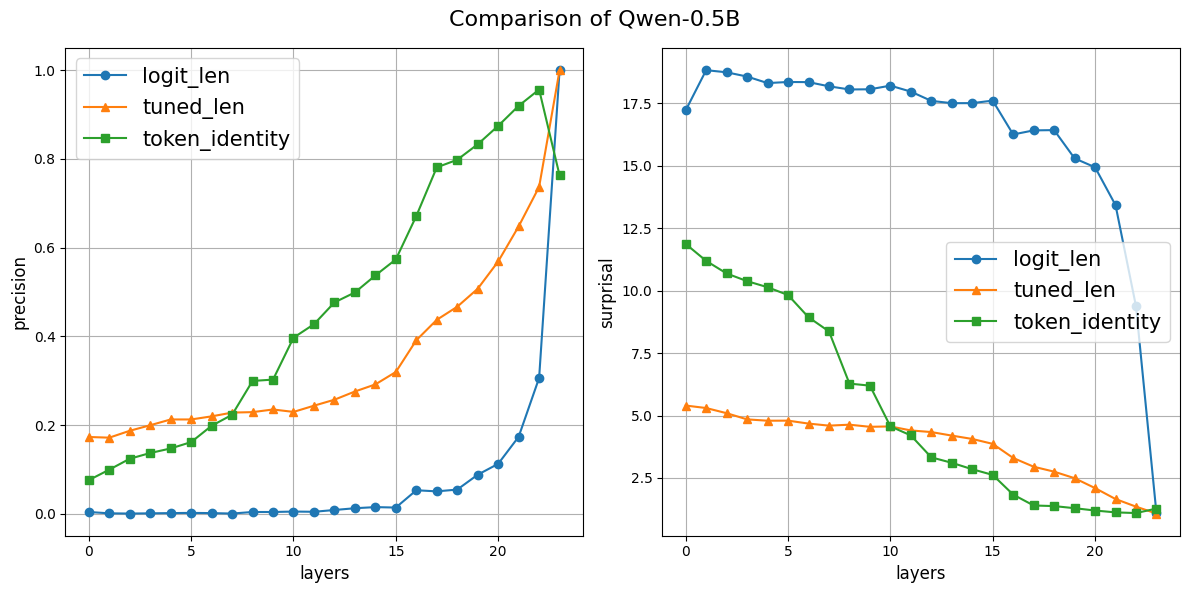

In [159]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Example dictionaries (replace these with your actual data)
dict1_list = [logit_len_p,logit_len_s]  # Example: linear increase
dict2_list = [tuned_len_p,tuned_len_s]  # Example: linear decrease
dict3_list = [token_identity_pre,token_identity_sup]  # Example: repeating pattern
ymarkers = ['precision', 'surprisal']
# Extract keys and values for each dictionary
x_values = list(dict1_list[0].keys())
for i in range(len(dict1_list)):
    y1 = list(dict1_list[i].values())
    y2 = list(dict2_list[i].values())
    y3 = list(dict3_list[i].values())
    y1  = [torch.Tensor.cpu(v) for v in y1]
    y2  = [torch.Tensor.cpu(v) for v in y2]
    y3  = [torch.Tensor.cpu(v) for v in y3]
    axes[i].plot(x_values,y1,label = 'logit_len',marker = 'o')
    axes[i].plot(x_values,y2,label = 'tuned_len',marker='^')
    axes[i].plot(x_values,y3, label = 'token_identity',marker='s')
    axes[i].set_xlabel('layers', fontsize=12)
    axes[i].set_ylabel(f'{ymarkers[i]}', fontsize=12)
    axes[i].grid(True)
    axes[i].legend(fontsize = 15)

fig.suptitle("Comparison of Qwen-0.5B", fontsize=16)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
# to check at the last layer if the logits are the same as the target logits